# Apple Classification with ResNet50

This notebook uses a single directory structure with subfolders `Apple_Bad` and `Apple_Good` under `dataset/`. It will:
- Load all images
- Shuffle them
- Split into training (70%), validation (15%), and test (15%) sets in memory
- Use ResNet50 with transfer learning to classify apples.

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os

print("TensorFlow version:", tf.__version__)
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))

TensorFlow version: 2.16.2
Num GPUs Available: 0


## Directory Setup
We have:
```
dataset/
    Apple_Bad/
    Apple_Good/
```

No separate train/val/test directories are needed. We'll split the dataset programmatically.

In [5]:
DATASET_DIR = "C:/Users/HP/Downloads/Appi"  # Ensure this path points to your 'dataset' folder

print("Dataset directory:", DATASET_DIR)
print("Classes:", os.listdir(DATASET_DIR))  # Should list ['Apple_Good', 'Apple_Bad'# Adjust if needed
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 15

# Load the full dataset
full_ds = tf.keras.preprocessing.image_dataset_from_directory(
    DATASET_DIR,
    seed=123,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='binary',
    shuffle=True
)

# Calculate number of images
full_count = full_ds.cardinality().numpy() * BATCH_SIZE
print("Total images:", full_count)

# Given ~1100 per class, total ~2200 images.
# Splitting: 70% train, 15% val, 15% test.
train_frac = 0.7
val_frac = 0.15
test_frac = 0.15

train_count = int(train_frac * full_count)
val_count = int(val_frac * full_count)
test_count = full_count - train_count - val_count

print("Train count:", train_count)
print("Val count:", val_count)
print("Test count:", test_count)

Dataset directory: C:/Users/HP/Downloads/Appi
Classes: ['Apple_Bad', 'Apple_Good']
Found 1748 files belonging to 2 classes.
Total images: 1760
Train count: 1232
Val count: 264
Test count: 264


## Splitting the Dataset
We'll take subsets from `full_ds` to create `train_ds`, `val_ds`, and `test_ds`.

Because `full_ds` is a `tf.data.Dataset`, we can use `.take()` and `.skip()` to split.

In [6]:
# full_ds is a collection of batches. Let's find how many batches we have.
full_batches = full_ds.cardinality().numpy()
print("Total batches:", full_batches)

# Calculate number of batches for each split
train_batches = train_count // BATCH_SIZE
val_batches = val_count // BATCH_SIZE
test_batches = test_count // BATCH_SIZE

# To ensure we use all images, if there's a remainder, it's typically small. We'll stick to these exact splits.

train_ds = full_ds.take(train_batches)
remaining = full_ds.skip(train_batches)

val_ds = remaining.take(val_batches)
test_ds = remaining.skip(val_batches)

# Check cardinalities
print("Train batches:", train_ds.cardinality().numpy())
print("Val batches:", val_ds.cardinality().numpy())
print("Test batches:", test_ds.cardinality().numpy())

Total batches: 55
Train batches: 38
Val batches: 8
Test batches: 9


## Class Names
Check the class names and confirm they match your directories.

In [7]:
class_names = full_ds.class_names
print("Class names:", class_names)

Class names: ['Apple_Bad', 'Apple_Good']


## Data Augmentation
We will apply data augmentation to the training set to handle variations in image orientation and dimension.

In [8]:
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom
from tensorflow.keras.applications.resnet50 import preprocess_input

data_augmentation = tf.keras.Sequential([
    RandomFlip("horizontal"),
    RandomRotation(0.1),
    RandomZoom(0.1)
])

def preprocess(image, label):
    # Preprocess for ResNet50
    image = preprocess_input(image)
    return image, label

# Augment training data
augmented_train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y))

# Preprocess train, val, test
augmented_train_ds = augmented_train_ds.map(preprocess)
val_ds = val_ds.map(preprocess)
test_ds = test_ds.map(preprocess)

AUTOTUNE = tf.data.AUTOTUNE
augmented_train_ds = augmented_train_ds.prefetch(AUTOTUNE)
val_ds = val_ds.prefetch(AUTOTUNE)
test_ds = test_ds.prefetch(AUTOTUNE)

## Model Setup (ResNet50)
- Use ResNet50 with ImageNet weights
- Freeze the base model initially
- Add a custom classification head

In [9]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, models

base_model = ResNet50(include_top=False, weights='imagenet', input_shape=IMG_SIZE+(3,))
base_model.trainable = False  # Freeze base model

inputs = tf.keras.Input(shape=IMG_SIZE+(3,))
x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(1, activation='sigmoid')(x)

model = models.Model(inputs, outputs)
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ resnet50 (Functional)                │ (None, 7, 7, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │           2,049 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,589,761 (89.99 MB)

 Trainable params: 2,049 (8.00 KB)

 Non-trainable params: 23,587,712 (89.98 MB)

## Compile and Train the Model

In [10]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    augmented_train_ds,
    validation_data=val_ds,
    epochs=EPOCHS
)

Epoch 1/15
38/38 ━━━━━━━━━━━━━━━━━━━━ 68s 2s/step - accuracy: 0.7661 - loss: 0.4665 - val_accuracy: 0.9766 - val_loss: 0.1071
Epoch 2/15
38/38 ━━━━━━━━━━━━━━━━━━━━ 60s 2s/step - accuracy: 0.9675 - loss: 0.1263 - val_accuracy: 0.9688 - val_loss: 0.0848
Epoch 3/15
38/38 ━━━━━━━━━━━━━━━━━━━━ 61s 2s/step - accuracy: 0.9712 - loss: 0.0934 - val_accuracy: 0.9844 - val_loss: 0.0600
Epoch 4/15
38/38 ━━━━━━━━━━━━━━━━━━━━ 61s 2s/step - accuracy: 0.9811 - loss: 0.0705 - val_accuracy: 1.0000 - val_loss: 0.0417
Epoch 5/15
38/38 ━━━━━━━━━━━━━━━━━━━━ 64s 2s/step - accuracy: 0.9790 - loss: 0.0673 - val_accuracy: 0.9961 - val_loss: 0.0346
Epoch 6/15
38/38 ━━━━━━━━━━━━━━━━━━━━ 62s 2s/step - accuracy: 0.9904 - loss: 0.0463 - val_accuracy: 0.9844 - val_loss: 0.0490
Epoch 7/15
38/38 ━━━━━━━━━━━━━━━━━━━━ 63s 2s/step - accuracy: 0.9915 - loss: 0.0378 - val_accuracy: 0.9961 - val_loss: 0.0321
Epoch 8/15
38/38 ━━━━━━━━━━━━━━━━━━━━ 63s 2s/step - accuracy: 0.9916 - loss: 0.0405 - val_accuracy: 0.9844 - val_loss:

## Evaluate the Model
We'll plot training/validation accuracy and loss.

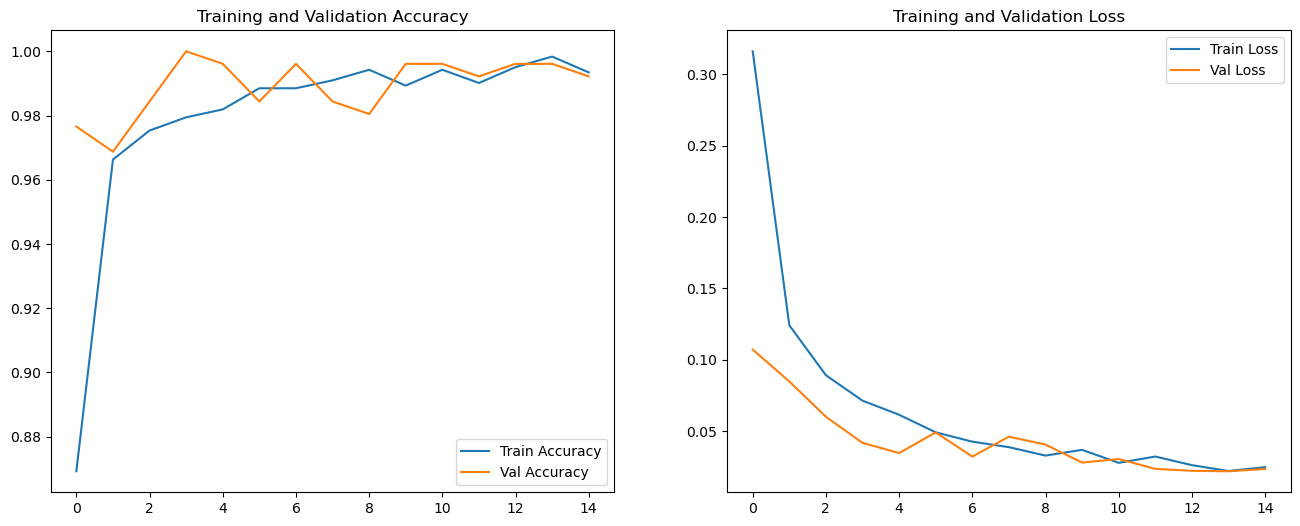

In [11]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(acc, label='Train Accuracy')
plt.plot(val_acc, label='Val Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(loss, label='Train Loss')
plt.plot(val_loss, label='Val Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.show()

## Fine-Tuning (Optional)
Unfreeze some layers of the base model and fine-tune with a lower learning rate if needed.

In [ ]:
# Unfreeze the base model
base_model.trainable = True

# Compile with a lower learning rate
model.compile(optimizer=tf.keras.optimizers.Adam(1e-5), loss='binary_crossentropy', metrics=['accuracy'])

fine_tune_epochs = 5
history_fine = model.fit(
    augmented_train_ds,
    validation_data=val_ds,
    epochs=fine_tune_epochs
)

## Test the Model on Unseen Data

In [12]:
test_loss, test_acc = model.evaluate(test_ds)
print("Test Accuracy:", test_acc)
print("Test Loss:", test_loss)

9/9 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.9793 - loss: 0.0350
Test Accuracy: 0.9818840622901917
Test Loss: 0.03306729719042778


## Save the Model

In [16]:
model.save('apple_classifier_resnet502.h5')
print("Model saved as apple_classifier_resnet502.h5")

Model saved as apple_classifier_resnet502.h5


## Making Predictions on New Images (Example)

Model loaded successfully.


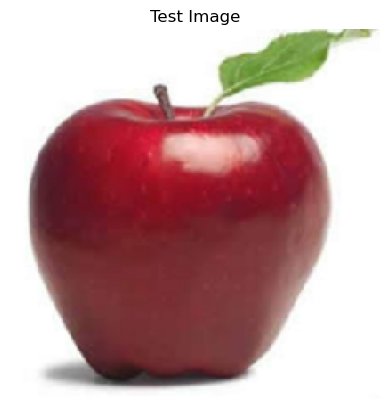

Image preprocessed successfully.
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Raw prediction score: 0.7453454732894897
Prediction: Good Apple


In [32]:
# Import necessary libraries
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input
import numpy as np
import matplotlib.pyplot as plt

# Define model path and test image path
model_path = 'C:/Users/HP/Downloads/apple_classifier_resnet502.h5'  # Update this to the correct path if needed
test_image_path = 'C:/Users/HP/Downloads/good_apple_test2.png'  # The image file for testing

# Define the image size used during training
IMG_SIZE = (224, 224)  # Must match the size used during training

# Load the trained model
try:
    model = load_model(model_path)
    print("Model loaded successfully.")
except Exception as e:
    print(f"Error loading model: {e}")
    raise

# Load and preprocess the test image
try:
    # Load the image and resize to match training input
    img = image.load_img(test_image_path, target_size=IMG_SIZE)
    
    # Display the image for verification
    plt.imshow(img)
    plt.title("Test Image")
    plt.axis('off')
    plt.show()
    
    # Convert the image to an array and expand dimensions
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)  # Preprocess to match ResNet50 input requirements
    print("Image preprocessed successfully.")
except Exception as e:
    print(f"Error processing the image: {e}")
    raise

# Perform prediction
try:
    pred = model.predict(x)
    print(f"Raw prediction score: {pred[0][0]}")


    # Interpret the prediction score
    if pred[0][0] > 0.15:
        result = "Good Apple"
    else:
        result = "Bad Apple"

    print(f"Prediction: {result}")
except Exception as e:
    print(f"Error during prediction: {e}")
    raise
